In [1]:
using Distributed
cpuNum = length(Sys.cpu_info()) 
# number of cpu cores

addprocs(cpuNum - 1);
# using all cpu cores

In [1]:
include("main.jl");
lisa = LISA();
lisa1 = LISA(transfer_file="RLISA1.txt");

	 Approximation will be used...

In [3]:
getSn(0.1)

1.61116119528411e-39

In [14]:
@everywhere include("main.jl");
@everywhere lisa = LISA();
lisa1 = LISA(transfer_file="RLISA1.txt");

	 Approximation will be used...

## Power-law integrated curve

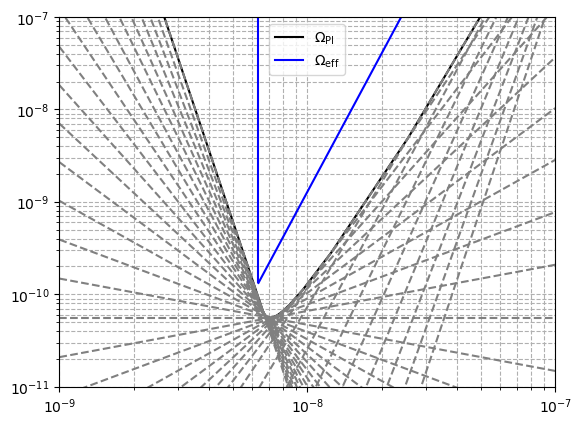

  0.281973 seconds (268.16 k allocations: 265.866 MiB, 8.57% gc time)


PyObject <matplotlib.legend.Legend object at 0x7fcd35055a20>

In [17]:
function plotΩPI(det::Detector; figure_file=nothing, 
        plotΩPI=true, plotΩeff=false, plotΩPILines=false)
    
    fs, ΩPIResult, ΩPILines  = ΩPI(det)
    Ωeffs = 5*det.Ωeff.(fs)
    
    xlim(det.fPlotRange)
    ylim(det.ΩPlotRange)    
    
    grid("on", which="both", linestyle="--")
    
    if plotΩPI != false
        loglog(fs, ΩPIResult, "black", label=L"Ω$_{\mathrm{PI}}$")        
    end
    
    if plotΩeff==true
        loglog(fs, Ωeffs, "b", label=L"Ω$_{\mathrm{eff}}$")
        if typeof(det)==PTA 
            vlines(det.fMin, 5*det.Ωeff(det.fMin), det.ΩPlotRange[2], "b")
        end
    end
    
    if plotΩPILines==true 
        [loglog(fs, ΩPILines[i], "--", color="gray") for i in 1:length(ΩPILines)]
    end
    
    legend()
end

det = PTA();
@time plotΩPI(det, plotΩeff=true, plotΩPILines=true)

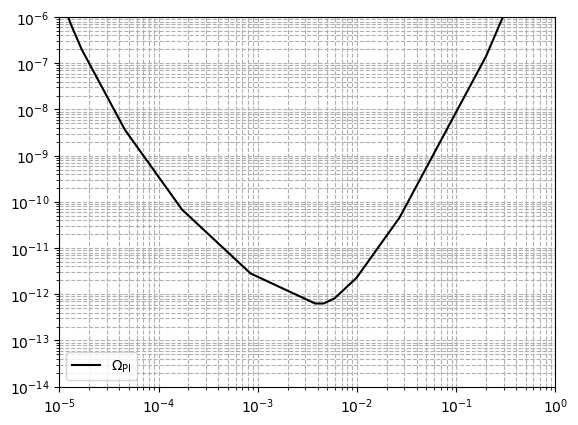

  3.302378 seconds (6.02 M allocations: 445.997 MiB, 2.63% gc time)


PyObject <matplotlib.legend.Legend object at 0x7f4d49c82940>

In [96]:
det = LISA(TObs=1.);
@time plotΩPI(det)

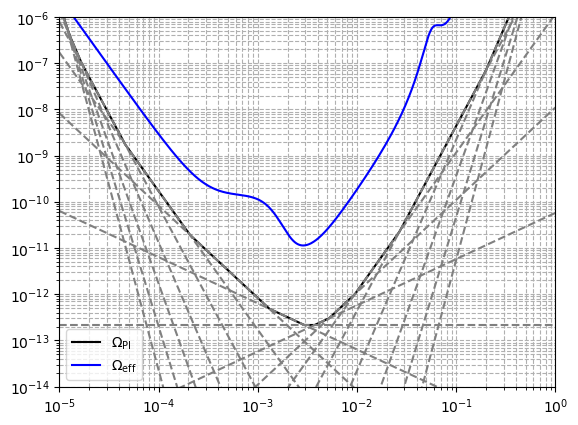

  3.280513 seconds (6.02 M allocations: 445.580 MiB, 2.59% gc time)


PyObject <matplotlib.legend.Legend object at 0x7f4d474427b8>

In [114]:
det = LISA();
@time plotΩPI(det, plotΩeff=true, plotΩPILines=true)

In [116]:
sqrt(YEAR)

5617.615152357805

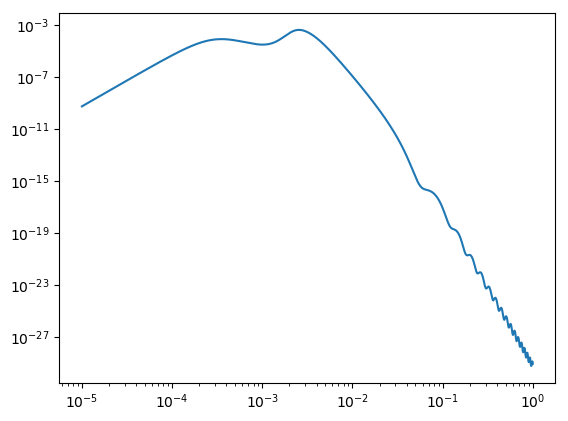

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4d4730bb70>

In [122]:
det = LISA();
fs = ΩPI(det)[1];
β = -1;
Ωβ = getΩβ(det, β) 
a(f) = (Ωgw(Ωβ, β)(f)/det.Ωeff(f))^2
a.(fs)
loglog(fs, a.(fs))

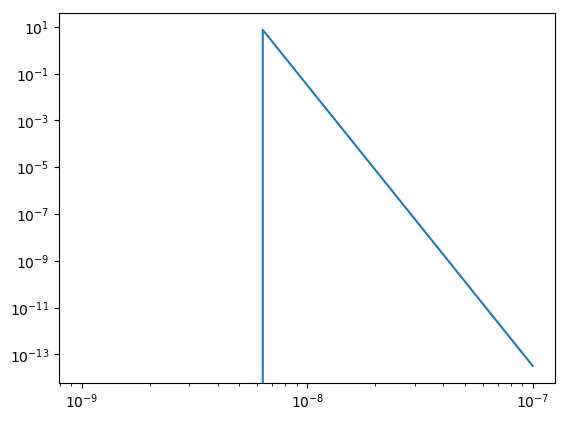

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4d48a80940>

In [159]:
det = PTA();
fs = ΩPI(det)[1];
β = -1;
Ωβ = getΩβ(det, β) 
a(f) = (Ωgw(Ωβ, β)(f)/det.Ωeff(f))^2
a.(fs)
loglog(fs, a.(fs))

In [155]:
b = quadgk(a, det.fMin, det.fMax, rtol=1e-3)[1]
sqrt(b) * sqrt(2 * 5 * YEAR) * 0.85

1.0

In [41]:
using HypergeometricFunctions

In [122]:
function test(f, β, Ωβ, Pn)
    f/(-5 + β) * (
    -(H0^2 * Ωβ)/(8*f^(5-β) * π^4 * Pn + H0^2 * Ωβ)        
    + (-4 + β) * _₂F₁(1, 1/(5-β), 1 + 1/(5-β), 
            -(8*f^(5-β) * π^4 * Pn)/(H0^2 * big(Ωβ)))
        )
end

test (generic function with 1 method)

In [123]:
det = PTA();
@time test(det.fMax, 10, 1e100, det.Pn(1))

  1.156819 seconds (1.48 M allocations: 67.794 MiB, 4.98% gc time)


3.168808781402894724580826860647897458430704835024075872010945031933246182093265e-07

In [124]:
function SNR(pta::PTA, β, Ωβ)
    fMin, fMax = pta.fMin, pta.fMax
    N = pta.nPTA
    Pn = pta.Pn(1.0)
    T = pta.TObs * YEAR
    integral = test(fMax, β, Ωβ, Pn) - test(fMin, β, Ωβ, Pn)
    ΓII = 1.0/(4.0*sqrt(3.0))
    result = sqrt(2 * T * N*(N-1)/2 * ΓII^2 * integral)
end

SNR (generic function with 3 methods)

In [125]:
pta = PTA();

18.69560018548982265920723911916934001923173220384550226453935481704994706619764

In [139]:
func1(Ωβ) = (SNR(pta, 8, Ωβ) - pta.ρThSGWB)
find_zero(func1, (1e-300, 1e100))

ArgumentError: ArgumentError: The interval [a,b] is not a bracketing interval.
You need f(a) and f(b) to have different signs (f(a) * f(b) < 0).
Consider a different bracket or try fzero(f, c) with an initial guess c.



In [ ]:
function getΩβ(pta::PTA, β) 
    integral(f) = f^(2*β)/det.Ωeff(f)^2
    
    fMin = det.fMin
    fMax = det.fMax
    
    # Eq.(29)
    coeff1 = typeof(det)==LISA ? 1. : 2.
    coeff2 = typeof(det)==PTA ? 1/0.85 : 1.
    
    result = quadgk(integral, fMin, fMax, rtol=1e-3)
    Ωβ = coeff2 * det.ρThSGWB * (coeff1 * det.TObs * YEAR * result[1])^(-1/2)
    
    Ωβ
end